In [1]:
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from scipy.stats import skew

np.warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=120, threshold=5000, edgeitems=50, suppress=True)

seed = 42

In [2]:
%%time
print('Reading: loan_stat542.csv into loans dataframe...')

loans = pd.read_csv('loan_stat542.csv')
print('Loans dataframe:', loans.shape)

test_ids = pd.read_csv('Project3_test_id.csv', dtype={'test1':int,'test2':int, 'test3':int,})
print('ids dataframe:', test_ids.shape)

trains = []
tests = []
labels = []
for i, col in enumerate(test_ids.columns):
    trains.append(loans.loc[~loans.id.isin(test_ids[col]),:])
    tests.append( loans.loc[ loans.id.isin(test_ids[col]), loans.columns!='loan_status'])
    labels.append(loans.loc[ loans.id.isin(test_ids[col]), ['id','loan_status']])
    labels[i]["y"] = (labels[i].loan_status != 'Fully Paid').astype(int)
    labels[i].drop('loan_status', axis=1, inplace=True)
    print('Fold', i, trains[i].shape, tests[i].shape, labels[i].shape)

print('Writing train, test, labels csv files...')
# fold=0
# _ = trains[fold].to_csv('train.csv', index=False)
# _ = tests [fold].to_csv('test.csv',  index=False)
# _ = labels[fold].to_csv('label.csv', index=False)
print('Done!')

Reading: loan_stat542.csv into loans dataframe...
Loans dataframe: (844006, 30)
ids dataframe: (253200, 3)
Fold 0 (590806, 30) (253200, 29) (253200, 2)
Fold 1 (590806, 30) (253200, 29) (253200, 2)
Fold 2 (590806, 30) (253200, 29) (253200, 2)
Writing train, test, labels csv files...
Done!
CPU times: user 3.84 s, sys: 468 ms, total: 4.3 s
Wall time: 4.33 s


In [3]:
def process(data):        
    data['emp_length'] = data.emp_length.fillna('Unknown').str.replace('<','LT')
    data['dti'] = data.dti.fillna(0)
    data['revol_util'] = data.revol_util.fillna(0)
    data['mort_acc'] = data.mort_acc.fillna(0)
    data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.fillna(0)
    temp = pd.to_datetime(data.earliest_cr_line)
    data['earliest_cr_line'] = temp.dt.year*12 - 1950*12 + temp.dt.month
    data.drop(['emp_title','title','zip_code','grade','fico_range_high'], axis=1, inplace=True)
    return data

def logloss(y, p):
    loglosses = np.where(y==1, -np.log(p+1e-15), -np.log(1-p+1e-15))
    return np.mean(loglosses)

def prep_train_test(train, test):    
    train = process(train)
    X_train = train.drop(['loan_status'], axis=1)
    X_train = pd.get_dummies(X_train) # create dataframe with dummy variables replacing categoricals
    X_train = X_train.reindex(sorted(X_train.columns), axis=1) # sort columns to be in same sequence as test
    y_train = (train.loan_status!='Fully Paid').astype(int)

    test = process(test)
    X_test = pd.get_dummies(test) # create dataframe with dummy variables replacing categoricals

    all_columns = X_train.columns.union(X_test.columns) # add columns to test that are in train but not test
    X_test = X_test.reindex(columns=all_columns).fillna(0)
    X_test = X_test.reindex(sorted(X_train.columns), axis=1) # sort columns to be in same sequence at train

    return X_train, y_train, X_test

In [4]:
train = trains[0].copy()
test = tests[0].copy()
label = labels[0].copy()
fraction = 1
if fraction < 1:
    train = train.sample(frac=fraction, random_state=seed)
    test  = test.sample(frac=fraction, random_state=seed)
print(train.shape)
X_train, y_train, X_test = prep_train_test(train, test)
print(X_train.shape, y_train.shape, X_test.shape) 

(590806, 30)
(590806, 142) (590806,) (253200, 142)


In [ ]:
gbm_params = {
      'learning_rate':      np.linspace(0.04, 0.08, 9),
      'n_estimators':       np.linspace(540, 1000, 24, dtype=int),
      'max_depth':          np.linspace(4, 10, 7, dtype=int),  
      'min_samples_split':  np.linspace(2, 6, 5, dtype=int),
      'min_samples_leaf':   np.linspace(2, 6, 5, dtype=int),    
      'min_weight_fraction_leaf': np.linspace(0, 0.05, 2),
      'subsample':          np.linspace(0.8, 1, 5),
      'max_features':       ('sqrt',), 
}

xgb_params = {
      'learning_rate':    np.linspace(0.01, 0.07, 13), 
      'n_estimators':     np.linspace(300, 900, 13, dtype=int),
      'min_child_weight': np.linspace(5, 9, 5, dtype=int), 
      'max_depth':        np.linspace(4, 9, 6, dtype=int), 
      'gamma':            np.linspace(0, 0.5, 11), 
      'subsample':        np.linspace(0.5, 1, 11),  
      'colsample_bytree': np.linspace(0.8, 1, 5),
      'reg_lambda':       np.linspace(0.6, 1, 9), 
      'reg_alpha':        np.linspace(0, 0.5, 11), 
      'silent':           [1,],
}

# base_model = GradientBoostingClassifier(random_state=seed)
base_model = xgb.XGBClassifier(n_estimators=150, objective= 'binary:logistic', random_state=seed, n_jobs=-1)
model = RandomizedSearchCV(base_model,n_iter=300,n_jobs=2, cv=ShuffleSplit(test_size=0.20,n_splits=1,random_state=0), 
                           param_distributions=xgb_params,scoring='neg_log_loss',
                           verbose=10, random_state=seed, return_train_score=False)

_ = model.fit(X_train, y_train)
print(model.best_estimator_)
print(model.best_params_)
print(-round(model.best_score_,6))      

In [ ]:
df = pd.DataFrame(model.cv_results_).sort_values(by='mean_test_score', ascending=False)
df.loc[:,df.columns!='params']

In [10]:
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_convergence
import datetime, warnings

def objective(values):    
    index = str(values)
    if index in cache:
        print('GET FROM CACHE:', index, round(cache[index],4))
        return cache[index]
    if model_type == 'LogisticRegression':
        params = {'penalty': values[0], 'C': values[1],}
        model = LogisticRegression(**params, random_state=seed, n_jobs=-1)
        
#     if model_type == 'RandomForestClassifier':
#         params = {'n_estimators': values[0], 'max_features': values[1], 'max_depth': values[2],}
#         model = RandomForestClassifier(**params, n_jobs=-1)
    
    if model_type == 'GradientBoostingClassifier':
        params = {'learning_rate': values[0], 'n_estimators': values[1], 'max_depth': values[2],
                  'min_samples_split': values[3], 'min_samples_leaf': values[4], 
                  'min_weight_fraction_leaf' : values[5], 'subsample': values[6], 'max_features': values[7] }
        model = GradientBoostingClassifier(**params, random_state=seed)
    
    if model_type == 'XGBClassifier':
        params = {'learning_rate': values[0], 'n_estimators': int(values[1]), 'min_child_weight': int(values[2]),
                  'max_depth': int(values[3]), 'gamma': values[4], 'subsample': values[5],
                  'colsample_bytree': values[6], 'lambda': values[7], 'alpha': values[8], 'eval_metric':'logloss'}
        model = xgb.XGBClassifier(**params, random_state=seed, n_jobs=8,silent=1)
        
    print(datetime.datetime.now().time().replace(microsecond=0), ', Params',params) 
#     scores = -cross_val_score(model, X_train, y_train, scoring="neg_log_loss", cv=5, n_jobs=-1)
    _ = model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    y_test = pd.merge(test[['id']], label, how='left', on='id')

    cache[index] = np.mean( logloss(y_test.y, probs) )
    return cache[index]

Iteration No: 1 started. Evaluating function at random point.
11:20:05 , Params {'learning_rate': 0.032472407130841756, 'n_estimators': 570, 'min_child_weight': 7, 'max_depth': 8, 'gamma': 0.29842507897324355, 'subsample': 0.7229163764267956, 'colsample_bytree': 0.8199949831636006, 'lambda': 0.7836995567863468, 'alpha': 0.16685430556951095, 'eval_metric': 'logloss'}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 447.0242
Function value obtained: 0.4393
Current minimum: 0.4393
Iteration No: 2 started. Evaluating function at random point.
11:27:32 , Params {'learning_rate': 0.018572009075316448, 'n_estimators': 430, 'min_child_weight': 9, 'max_depth': 5, 'gamma': 0.3609993861334124, 'subsample': 0.9692763545078752, 'colsample_bytree': 0.8001557531682029, 'lambda': 0.996884623716487, 'alpha': 0.3087407548138583, 'eval_metric': 'logloss'}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 184.5864
Function value obtained: 0.4439
Current minimum: 0.4393

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 325.1661
Function value obtained: 0.4416
Current minimum: 0.4390
Iteration No: 18 started. Searching for the next optimal point.
13:23:42 , Params {'learning_rate': 0.04292561806613531, 'n_estimators': 846, 'min_child_weight': 5, 'max_depth': 9, 'gamma': 0.3083706706585818, 'subsample': 0.9826626429973844, 'colsample_bytree': 0.909811816338645, 'lambda': 0.6848703222450128, 'alpha': 0.01927362866821281, 'eval_metric': 'logloss'}
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 691.4619
Function value obtained: 0.4398
Current minimum: 0.4390
Iteration No: 19 started. Searching for the next optimal point.
13:35:13 , Params {'learning_rate': 0.06506569609297086, 'n_estimators': 857, 'min_child_weight': 6, 'max_depth': 8, 'gamma': 0.3427445488422126, 'subsample': 0.6506047694323046, 'colsample_bytree': 0.8005724711222457, 'lambda': 0.6201824077171363, 'alpha': 0.05586489967522863,

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 212.8185
Function value obtained: 0.4429
Current minimum: 0.4390
Iteration No: 34 started. Searching for the next optimal point.
15:29:13 , Params {'learning_rate': 0.01183149525605268, 'n_estimators': 594, 'min_child_weight': 9, 'max_depth': 5, 'gamma': 0.27721416426605866, 'subsample': 0.5675303006399686, 'colsample_bytree': 0.8903036547066469, 'lambda': 0.6371178174495238, 'alpha': 0.16005674348056873, 'eval_metric': 'logloss'}
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 326.7292
Function value obtained: 0.4441
Current minimum: 0.4390
Iteration No: 35 started. Searching for the next optimal point.
15:34:40 , Params {'learning_rate': 0.011925958532415015, 'n_estimators': 396, 'min_child_weight': 9, 'max_depth': 5, 'gamma': 0.012648565994462572, 'subsample': 0.8493241444594181, 'colsample_bytree': 0.9537416611158581, 'lambda': 0.7163978383666009, 'alpha': 0.3436890307893

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 122.1584
Function value obtained: 0.4504
Current minimum: 0.4390
Iteration No: 50 started. Searching for the next optimal point.
17:09:30 , Params {'learning_rate': 0.012091066540569712, 'n_estimators': 375, 'min_child_weight': 7, 'max_depth': 5, 'gamma': 0.2666993227879508, 'subsample': 0.7574769023561233, 'colsample_bytree': 0.8647799204181779, 'lambda': 0.848164331205967, 'alpha': 0.4847526179361339, 'eval_metric': 'logloss'}
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 181.6646
Function value obtained: 0.4467
Current minimum: 0.4390
Iteration No: 51 started. Searching for the next optimal point.
17:12:32 , Params {'learning_rate': 0.011985939362168265, 'n_estimators': 442, 'min_child_weight': 5, 'max_depth': 6, 'gamma': 0.3551130166630681, 'subsample': 0.6764143076154374, 'colsample_bytree': 0.8986002234623314, 'lambda': 0.9819184311094402, 'alpha': 0.49647698407838786

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 767.2642
Function value obtained: 0.4394
Current minimum: 0.4390
Iteration No: 66 started. Searching for the next optimal point.
18:07:40 , Params {'learning_rate': 0.011681769620496461, 'n_estimators': 305, 'min_child_weight': 6, 'max_depth': 4, 'gamma': 0.45783509869204203, 'subsample': 0.533002772762959, 'colsample_bytree': 0.8119252909798433, 'lambda': 0.7394642188551581, 'alpha': 0.26759006706680005, 'eval_metric': 'logloss'}
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 214.3905
Function value obtained: 0.4510
Current minimum: 0.4390
Iteration No: 67 started. Searching for the next optimal point.
18:11:15 , Params {'learning_rate': 0.03437350012644514, 'n_estimators': 303, 'min_child_weight': 7, 'max_depth': 9, 'gamma': 0.3311406707752367, 'subsample': 0.5766936808669674, 'colsample_bytree': 0.8416496957198666, 'lambda': 0.7631865709660455, 'alpha': 0.0627887109774839

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 236.4699
Function value obtained: 0.4398
Current minimum: 0.4390
Iteration No: 82 started. Searching for the next optimal point.
19:13:43 , Params {'learning_rate': 0.011081065364768898, 'n_estimators': 303, 'min_child_weight': 8, 'max_depth': 4, 'gamma': 0.16335442463137886, 'subsample': 0.6374377997463996, 'colsample_bytree': 0.874295048448734, 'lambda': 0.6637151895474483, 'alpha': 0.11062419682366045, 'eval_metric': 'logloss'}
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 128.8081
Function value obtained: 0.4519
Current minimum: 0.4390
Iteration No: 83 started. Searching for the next optimal point.
19:15:52 , Params {'learning_rate': 0.010055567992499148, 'n_estimators': 304, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.4351900796272296, 'subsample': 0.765663871427064, 'colsample_bytree': 0.8492990473275075, 'lambda': 0.8247620486062637, 'alpha': 0.1355609923230687

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 300.5500
Function value obtained: 0.4398
Current minimum: 0.4390
Iteration No: 98 started. Searching for the next optimal point.
20:36:17 , Params {'learning_rate': 0.011276332245560298, 'n_estimators': 895, 'min_child_weight': 6, 'max_depth': 7, 'gamma': 0.033197985061516895, 'subsample': 0.800254575753599, 'colsample_bytree': 0.9276324414605639, 'lambda': 0.8051247531273129, 'alpha': 0.340061090102046, 'eval_metric': 'logloss'}
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 554.7041
Function value obtained: 0.4411
Current minimum: 0.4390
Iteration No: 99 started. Searching for the next optimal point.
20:45:31 , Params {'learning_rate': 0.06902094946530948, 'n_estimators': 419, 'min_child_weight': 6, 'max_depth': 4, 'gamma': 0.1131154073303828, 'subsample': 0.5217723390632322, 'colsample_bytree': 0.9083082929197663, 'lambda': 0.6204962574338669, 'alpha': 0.3506191309321791,

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 205.5381
Function value obtained: 0.4514
Current minimum: 0.4390
Iteration No: 114 started. Searching for the next optimal point.
22:34:47 , Params {'learning_rate': 0.06796107003152577, 'n_estimators': 314, 'min_child_weight': 9, 'max_depth': 4, 'gamma': 0.009487630321292963, 'subsample': 0.7964240407381178, 'colsample_bytree': 0.856162443308825, 'lambda': 0.9993689521383164, 'alpha': 0.08996841618491287, 'eval_metric': 'logloss'}
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 210.1609
Function value obtained: 0.4419
Current minimum: 0.4390
Iteration No: 115 started. Searching for the next optimal point.
22:38:18 , Params {'learning_rate': 0.010040633899231514, 'n_estimators': 304, 'min_child_weight': 6, 'max_depth': 9, 'gamma': 0.35604869921811, 'subsample': 0.6612108709644472, 'colsample_bytree': 0.9733446398638465, 'lambda': 0.6061571079984339, 'alpha': 0.4451801325947

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 311.3043
Function value obtained: 0.4443
Current minimum: 0.4390
Iteration No: 130 started. Searching for the next optimal point.
23:53:04 , Params {'learning_rate': 0.01033593285693411, 'n_estimators': 304, 'min_child_weight': 8, 'max_depth': 4, 'gamma': 0.22882725481816557, 'subsample': 0.9213872810740582, 'colsample_bytree': 0.9058881191516513, 'lambda': 0.7303846217337924, 'alpha': 0.4107198347806353, 'eval_metric': 'logloss'}
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 96.0185
Function value obtained: 0.4530
Current minimum: 0.4390
Iteration No: 131 started. Searching for the next optimal point.
23:54:40 , Params {'learning_rate': 0.012095187185754867, 'n_estimators': 893, 'min_child_weight': 6, 'max_depth': 4, 'gamma': 0.19425194426422454, 'subsample': 0.9223633539836935, 'colsample_bytree': 0.8447991655740335, 'lambda': 0.8008831295867239, 'alpha': 0.029544980510

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 174.4518
Function value obtained: 0.4471
Current minimum: 0.4390
Iteration No: 146 started. Searching for the next optimal point.
00:53:32 , Params {'learning_rate': 0.06964597016754312, 'n_estimators': 302, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.18482670260824688, 'subsample': 0.9935838838950946, 'colsample_bytree': 0.9244739238598831, 'lambda': 0.6740870860237851, 'alpha': 0.25942909600041997, 'eval_metric': 'logloss'}
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 94.2284
Function value obtained: 0.4422
Current minimum: 0.4390
Iteration No: 147 started. Searching for the next optimal point.
00:55:06 , Params {'learning_rate': 0.010043727695454143, 'n_estimators': 900, 'min_child_weight': 5, 'max_depth': 8, 'gamma': 0.041929839612090854, 'subsample': 0.8113515558944862, 'colsample_bytree': 0.9236723432588053, 'lambda': 0.850181041850564, 'alpha': 0.25510954207

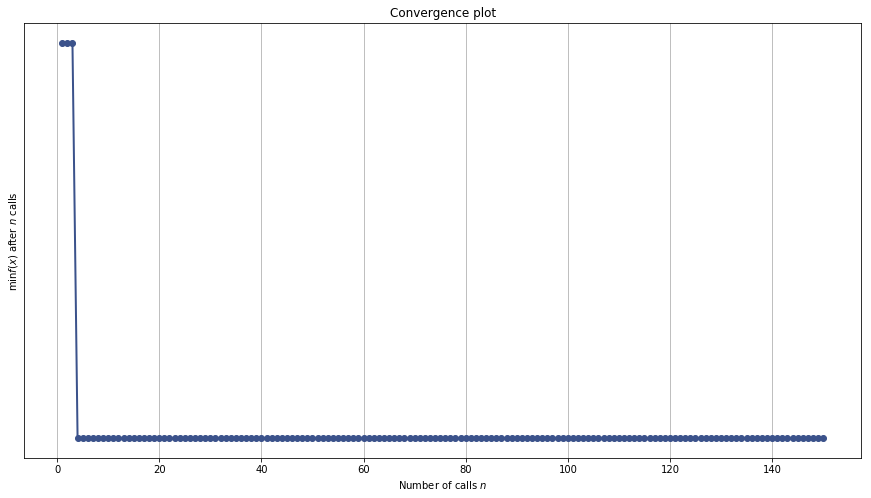

In [12]:
# %%time
import warnings
np.random.seed(seed)
warnings.filterwarnings("ignore", category=UserWarning) # turn off already evaluated errors
params={'LogisticRegression': [ 
                ['l1',],
                (1e-1,1e+1,'uniform'),
                ],
        'GradientBoostingClassifier': [ 
                (0.04, 0.10, 'uniform'),     # learning rate
                (500, 900),                  # n_estimators
                (3, 7),                      # max_depth   
                (2, 5),                      # min_samples_split 
                (2, 5),                      # min_samples_leaf 
                (0, 0.3),                    # min_weight_fraction_leaf 
                (0.8, 1.0,'uniform'),        # subsample 
                ('sqrt',),                   # max_features 
                ],
        'XGBClassifier': [
                (0.01, 0.07, 'uniform'),    # learning_rate 0.05, 0.3,
                (300, 900),                 # n_estimators
                (5, 9),                     # min_child_weight 
                (4, 9),                     # max_depth 3-10
                (0, 0.5,   'uniform'),      # gamma 0-0.4
                (0.5, 1.0, 'uniform'),      # subsample 0.5 - 0.99
                (0.8, 1.0, 'uniform'),      # colsample_bytree 0.5 - 0.99
                (0.6, 1.0, 'uniform'),      # reg_lambda
                (0.0, 0.5, 'uniform'),      # reg_alpha
                ],}

model_types = params.keys()
model_types = ['XGBClassifier']
for model_type in model_types:
    cache = {}
    space = params[model_type]
    result = gbrt_minimize(objective,space,n_random_starts=5, n_calls=150, random_state=seed,verbose=True,n_jobs=-1)
    print('\n', model_type, ', Best Params=', result.x, ' Best Score=', round(result.fun,6),'\n')
    _ = plt.figure(figsize=(15,8))
    _ = plot_convergence(result, yscale='log')

warnings.filterwarnings("default", category=UserWarning) # turn on already evaluated errors

In [17]:
sorted_d = sorted(cache.items(), key=lambda x: x[1])
temp = []
for i in range(len(sorted_d)):
    temp.append((sorted_d[i][0], round(sorted_d[i][1],5)))
    print('{:10.5} {}'.format(round(sorted_d[i][1],5), sorted_d[i][0]))

   0.43898 [0.037364199053022164, 862, 8, 7, 0.2962072844310213, 0.5232252063599989, 0.9215089703802877, 0.6682096494749166, 0.032525796492639765]
   0.43902 [0.028171385913113203, 868, 7, 8, 0.1399151764524502, 0.5105537312591736, 0.9717820488325419, 0.7328192598050536, 0.13784916014174478]
   0.43935 [0.06999636320210119, 547, 9, 6, 0.47300557467939824, 0.840721573913128, 0.9674318020887959, 0.7082316742921232, 0.45715037256998475]
   0.43935 [0.032472407130841756, 570, 7, 8, 0.29842507897324355, 0.7229163764267956, 0.8199949831636006, 0.7836995567863468, 0.16685430556951095]
   0.43936 [0.046028228015114137, 889, 8, 7, 0.1778621953347557, 0.6066553844532139, 0.9902486270504814, 0.6512632065360177, 0.48242601373407357]
   0.43941 [0.03846456690019029, 580, 8, 9, 0.19591768602605958, 0.5001098055099563, 0.9942481028825481, 0.7727896257424588, 0.1389799102992955]
   0.43956 [0.0669331322352, 615, 6, 5, 0.15230688458668537, 0.5488360570031919, 0.9368466053024314, 0.7760609974958406, 0.0